In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout,LeakyReLU, ELU, Flatten, AveragePooling2D, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.python.client import device_lib

print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_built_with_cuda() 

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [10]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [11]:
def data_crop(X):
    return X[:,:,0:500]

def data_augmentation(x):
    filter_x = np.zeros(x.shape)
    filter_low_pass = np.zeros(x.shape[2])
    for ii in range(500):
        if ii < 100:
            filter_low_pass[ii] = 1
        if ii >= 100 and ii < 125:
            filter_low_pass[ii] = (125 - ii)/30+0.1
        if ii >= 125 and ii < 375:
            filter_low_pass[ii] = 0.1
        if ii >= 375 and ii < 400:
            filter_low_pass[ii] = (-375 + ii)/30+0.1
        if ii >= 400 and ii < 500:           
            filter_low_pass[ii] = 1
    
    for ii in range(x.shape[0]):
        for jj in range(x.shape[1]):
            temp_x = x[ii,jj,:]
            fft_x = np.fft.fft(temp_x)
            fft_x_filter = fft_x*filter_low_pass
            filter_x[ii,jj,:] = np.real(np.fft.ifft(fft_x_filter))
    return filter_x
    

3


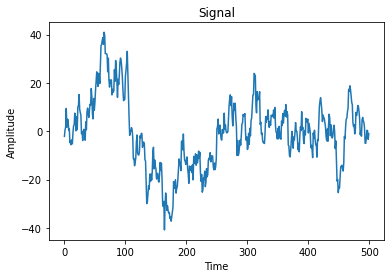

3


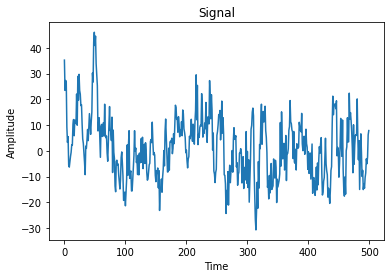

In [12]:
x_train = data_crop(X_train_valid)

x_train = x_train.reshape(2115, 22, 500)
y_train = to_categorical((y_train_valid - 769), 4)

# x_train, y_train = data_augmentation(x_train,y_train)

fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), x_train[1,5,:], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(y_train_valid[1]-769)

plt.show()

# generate a random permutation of indices
perm = np.random.permutation(len(x_train))

# shuffle the training data and labels using the permutation
x_train = x_train[perm]
y_train = y_train[perm]


fig, axs = plt.subplots()
axs.set_title("Signal")
axs.plot(range(500), x_train[1,5,:], color='C0')
axs.set_xlabel("Time")
axs.set_ylabel("Amplitude")
print(y_train_valid[1]-769)

plt.show()

# x_valid = x_train[3701:4229,:,:]
# y_valid = y_train[3701:4229,:]

# x_train = x_train[0:3700,:,:]
# y_train = y_train[0:3700,:]

x_valid = x_train[1701:2114,:,:]
y_valid = y_train[1701:2114,:]

x_train = x_train[0:1700,:,:]
y_train = y_train[0:1700,:]

x_test = data_crop(X_test)
x_test = x_test.reshape(443, 22, 500)
y_test = to_categorical((y_test - 769), 4)

In [35]:
# Define an input layer for grayscale image
inputs = keras.Input(shape=(22,500), name="EEG")

x = tf.keras.layers.Permute((2,1), name = 'permute-0')(inputs)

x = keras.layers.Bidirectional(LSTM(16, input_shape=(500, 22), return_sequences=True, kernel_regularizer=L1L2(0,0.01), 
                      recurrent_regularizer=L1L2(0,0.01), name="LSTM-1"))(x)
x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-1')(x)
x = keras.layers.ELU()(x)
x = keras.layers.Dropout(0.5, name = 'Dropout-1')(x)


x = keras.layers.Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=L1L2(0,0.01), 
                      recurrent_regularizer=L1L2(0,0.1), name="LSTM-2"))(x)
x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-2')(x)
x = keras.layers.ELU()(x)
x = keras.layers.Dropout(0.5, name = 'Dropout-2')(x)

x = keras.layers.Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=L1L2(0,0.01), 
                      recurrent_regularizer=L1L2(0,0.01), name="LSTM-3"))(x)
x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-3')(x)
x = keras.layers.ELU()(x)
x = keras.layers.Dropout(0.1, name = 'Dropout-3')(x)

# Adding a flattening operation 
x = keras.layers.Flatten()(x) 

x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-3-1')(x)
x = keras.layers.ELU()(x)
x = keras.layers.Dropout(0.1, name = 'Dropout-3-1')(x)

x = keras.layers.Dense(100)(x)
x = keras.layers.BatchNormalization(center=True, scale=True, name = 'BN-4-1')(x)
x = keras.layers.ELU()(x)
x = keras.layers.Dropout(0.1, name = 'Dropout-4-1')(x)

# Output layer with Softmax activation 
class_probs = keras.layers.Dense(4, kernel_regularizer=L1L2(l1 = 0, l2 = 0.01), activation='softmax')(x) # Output FC layer with softmax activation

# now wrap the model inputs and outputs
model = keras.Model(inputs=inputs, outputs=class_probs, name="eeg_resnet")

model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8), metrics=[keras.metrics.categorical_accuracy])
    

# Printing the model summary
model.summary()

Model: "eeg_resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EEG (InputLayer)            [(None, 22, 500)]         0         
                                                                 
 permute-0 (Permute)         (None, 500, 22)           0         
                                                                 
 bidirectional_27 (Bidirecti  (None, 500, 32)          4992      
 onal)                                                           
                                                                 
 BN-1 (BatchNormalization)   (None, 500, 32)           128       
                                                                 
 elu_45 (ELU)                (None, 500, 32)           0         
                                                                 
 Dropout-1 (Dropout)         (None, 500, 32)           0         
                                                        

In [36]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime
from keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.optimizers import Adam

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 3, factor = 0.5)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# Model parameters
lr =5e-5
epochs = 25
opt = Adam(learning_rate=lr)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = model.fit(x_train,
             y_train,
             batch_size=20,
             epochs=epochs,
             callbacks=[tb_callback, lr_callback],                    
             validation_data=(x_valid, y_valid), verbose=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/25
85/85 [==============================] - 31s 268ms/step - loss: 13.2813 - accuracy: 0.3512 - val_loss: 12.5728 - val_accuracy: 0.4116 - lr: 5.0000e-05
Epoch 2/25
85/85 [==============================] - 20s 241ms/step - loss: 12.1507 - accuracy: 0.5694 - val_loss: 12.0618 - val_accuracy: 0.4625 - lr: 5.0000e-05
Epoch 3/25
85/85 [==============================] - 21s 243ms/step - loss: 11.4445 - accuracy: 0.6441 - val_loss: 11.6877 - val_accuracy: 0.4407 - lr: 5.0000e-05
Epoch 4/25
85/85 [==============================] - 20s 240ms/step - loss: 10.8643 - accuracy: 0.6882 - val_loss: 11.2991 - val_accuracy: 0.4600 - lr: 5.0000e-05
Epoch 5/25
85/85 [==============================] - 20s 238ms/step - loss: 10.3292 - accuracy: 0.7159 - val_loss: 11.0097 - val_accuracy: 0.4746 - lr: 5.0000e-05
Epoch 6/25
85/85 [==============================] - 20s 238ms/step - loss: 9.7662 - accuracy: 0.8000

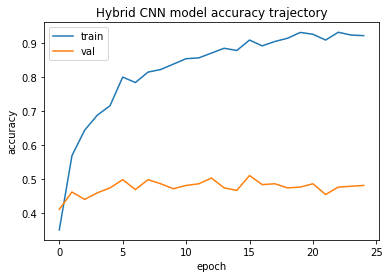

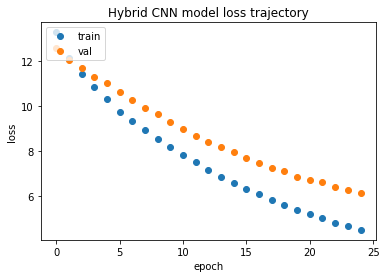

In [37]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.5011286735534668


In [39]:

# Save the model weights
model.save_weights('C:\ECE C247\Final_project\project\BestModel_RNN\weights')

# Save the model architecture
with open('C:/ECE C247/Final_project/project/BestModel_RNN/architecture.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
# Load the model architecture
with open('C:/ECE C247/Final_project/project/BestModel_RNN/architecture.json', 'r') as f:
    model_architecture = f.read()

# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(model_architecture)

# Load the model weights
loaded_model.load_weights('C:\ECE C247\Final_project\project\BestModel_RNN\weights')

# Compile the model
loaded_model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

hybrid_cnn_lstm_score = loaded_model.evaluate(x_test,y_test, verbose=0)
print('Test accuracy of the hybrid model:',hybrid_cnn_lstm_score[1])